In [34]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m
import cantera as ct


In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from src.data import get_nonlinear_data,hopf
from src.edmd import TruncEDMD
from src.kernels import RBFKernel
from src.training_edmd import GD_edmd_training
from src.visualizations import legend_without_duplicate_labels,gridsearch,traininglandscape,dynamicshopf
from matplotlib.legend_handler import HandlerTuple

In [38]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

Define intiial conditions and time interval then plot the result of the original system

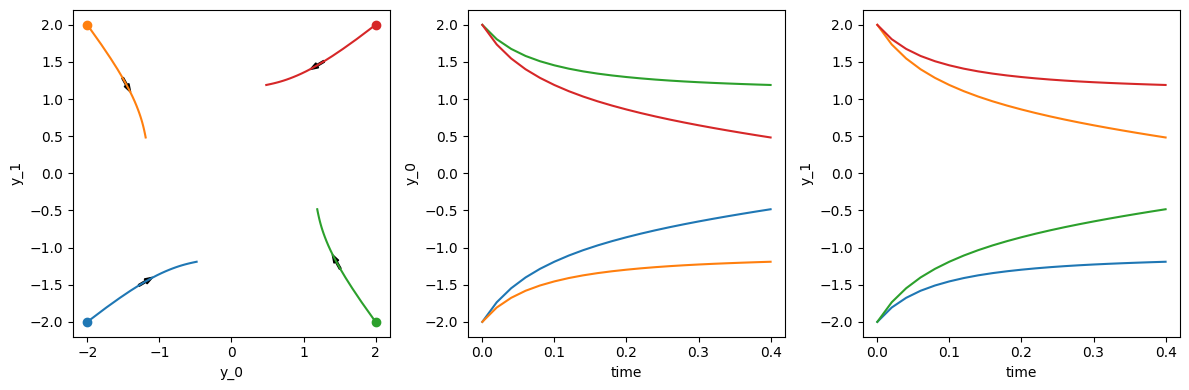

In [39]:
dynamic_system="hopf"
f, ax = plt.subplots(1, 3, figsize=(12, 4))
timesteps=21
factor=1
t_end=0.4
t_eval=np.linspace(0, t_end, timesteps)
df_Original=pd.DataFrame()
factor=1


initial_conditions = np.array(np.meshgrid(np.linspace(-2, 2,2), np.linspace(-2, 2, 2))).T.reshape(-1, 2)

x = np.zeros((len(initial_conditions)*(timesteps-1), 2))
y = np.zeros((len(initial_conditions)*(timesteps-1), 2))
original= np.zeros((len(initial_conditions)*(timesteps), 2))

x,y,original,t_eval_frac=dynamicshopf(hopf,initial_conditions,t_end,timesteps,factor)
   


#plot wiht arrows
for ic, condition in enumerate(initial_conditions):
   
    #print(condition.shape)
    ax[0].scatter(condition[0],condition[1],)
    ax[0].plot(original[ic*(timesteps):ic*(timesteps)+(timesteps), 0],original[ic*(timesteps):ic*(timesteps)+(timesteps), 1],
              )
    x=original[ic*(timesteps)+(timesteps)//5, 0]
    y=original[ic*(timesteps)+(timesteps)//5, 1]
    dx=original[ic*(timesteps)+(timesteps)//5+1, 0]-original[ic*(timesteps)+(timesteps)//5, 0]
    dy=original[ic*(timesteps)+(timesteps)//5+1, 1]-original[ic*(timesteps)+(timesteps)//5, 1]
    ax[0].arrow(x,y,dx,dy,width=0.025,color="black")
    ax[1].plot(t_eval,original[ic*(timesteps):ic*(timesteps)+(timesteps), 0])
    ax[2].plot(t_eval,original[ic*(timesteps):ic*(timesteps)+(timesteps), 1])
    ax[0].set_xlabel("y_0")
    ax[0].set_ylabel("y_1")
    ax[2].set_xlabel("time")
    ax[2].set_ylabel("y_1")
    ax[1].set_xlabel("time")
    ax[1].set_ylabel("y_0")
    f.tight_layout()
  




Perform Grid search

In [41]:

initial_conditions = np.array(np.meshgrid(np.linspace(-2,2,8), np.linspace(-2, 2,8))).T.reshape(-1, 2)
initial_conditions_sample=np.array([[1.6,1.6],[0.75,0.75],[-.4,-0.4]])
method = TruncEDMD()
parameters = np.array([0.1,1.0,2.0])#np.array([0.1,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0])
truncs=np.array([10,11,12])#np.array([10,11,12,14,16,18,20,22,24,26,28,30,32,34,36,38])
factors=np.array([1])
timesteps=20
t_end=0.4#0.0006
index=0
init_param=torch.tensor(0.1,requires_grad=True)
kernel = RBFKernel



lossperstep,OOSlossperstep,optim=gridsearch(factors,truncs,parameters,initial_conditions,
                                            initial_conditions_sample,timesteps,t_end,method,kernel,hopf)



Plot Results of Grid Search

(array([3], dtype=int64), array([12], dtype=int64))


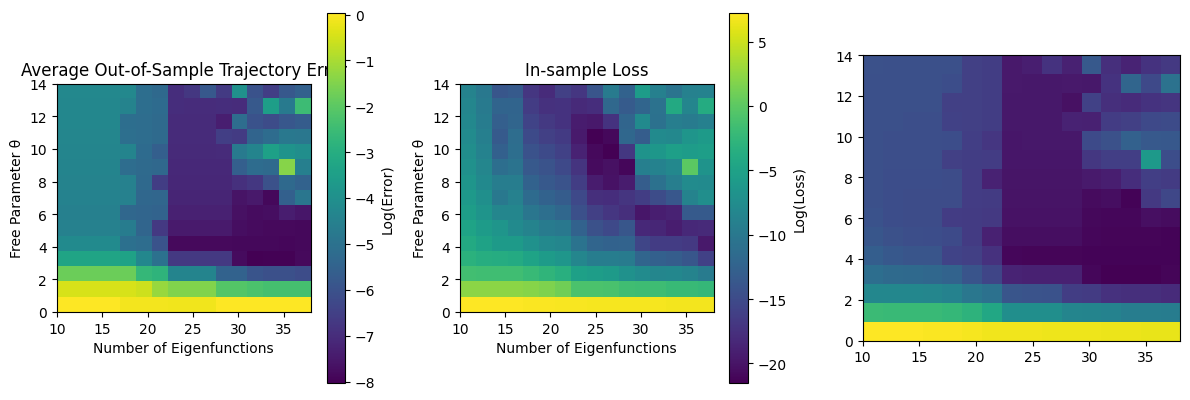

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))  


im1 = ax[0].imshow(np.log(OOSlossperstep),extent=(10,38,0,14),aspect=1.8,origin="lower")
cbar1 = fig.colorbar(im1, ax=ax[0],shrink=0.65)  
cbar1.set_label("Log(Error)")
ax[0].set_xlabel("Number of Eigenfunctions")
ax[0].set_ylabel("Free Parameter θ")

ax[0].set_title("Average Out-of-Sample Trajectory Error")  


im2 = ax[1].imshow(np.log(lossperstep),extent=(10,38,0,14),aspect=1.8,origin="lower")
cbar2 = fig.colorbar(im2, ax=ax[1],shrink=0.65) 

ax[1].set_xlabel("Number of Eigenfunctions")
ax[1].set_ylabel("Free Parameter θ")
ax[1].set_title("In-sample Loss")  
cbar2.set_label("Log(Loss)")

im2 = ax[2].imshow(np.log(optim),extent=(10,38,0,14),aspect=1.8,origin="lower")

plt.tight_layout()
min=np.where(optim == np.nanmin(optim))
print(min)

plt.show()


Explore the training landscape

In [49]:
#x_next_DMD=edmd.trajectory_visualization_DMD(x,y,LinearKernel())
initial_conditions =  np.array(np.meshgrid(np.linspace(-2,2,8), np.linspace(-2, 2,8))).T.reshape(-1, 2)
t_end=0.4#0.0006
timesteps=20
trunc=25
method = TruncEDMD()
factor=1
kernel = RBFKernel
parameters = np.linspace(0.1, 20, num=5)
func= hopf


losstrain,min_loss =traininglandscape(initial_conditions,t_end,timesteps,factor,
                    trunc,method,kernel,parameters,func)



Plot the Training Landscape

[1.01245626e+03 7.02593167e-07 5.11346845e-10 1.47726094e-06
 1.02617782e-04]
[ 0.1    5.075 10.05  15.025 20.   ]
max 1012.4562645319106
min 5.113468453069101e-10
(array([2], dtype=int64),)


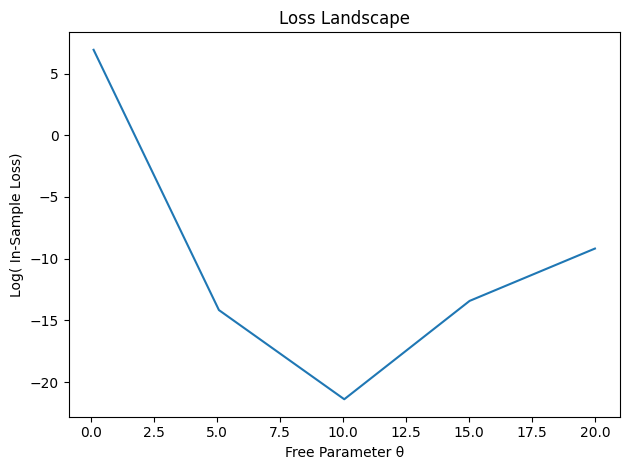

In [51]:
f, ax = plt.subplots()
print(losstrain)
print(parameters)
ax.plot( parameters, np.log(losstrain), label='Training Loss')


ax.set_xlabel('Free Parameter θ')
ax.set_ylabel('Log( In-Sample Loss)')
ax.set_title("Loss Landscape") 

f.tight_layout()

print("max",np.max(losstrain))
print("min",np.min(losstrain))
print(np.where(losstrain==np.min(losstrain)))


Perform Training using optimized paramters

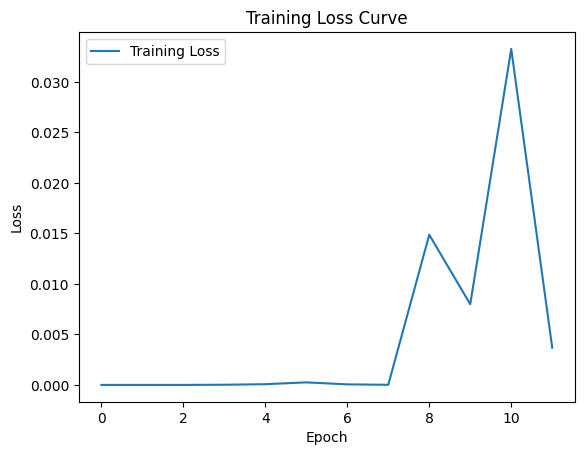

[Parameter containing:
tensor(17.8671, requires_grad=True)]


In [52]:
method = TruncEDMD()
parameter = torch.tensor(2.0, requires_grad=True)
kernel = RBFKernel([parameter])
initial_conditions = np.array(np.meshgrid(np.linspace(-2,2,2), np.linspace(-2, 2,2))).T.reshape(-1, 2)
t_end=0.4#0.0006
timesteps=20

trunc=32
func= hopf
num_epochs=12
x,y,original,t_eval=dynamicshopf(func,initial_conditions,t_end,timesteps,factor)

train_loss,min_loss = GD_edmd_training(num_epochs,1, x.T, y.T, kernel, method,trunc, lr=1e-1,full=True, penalty=True)

fig, ax = plt.subplots()
plt.plot( np.array(range(0,num_epochs)), train_loss, label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()
print(list(kernel.parameters()))


visualize training 

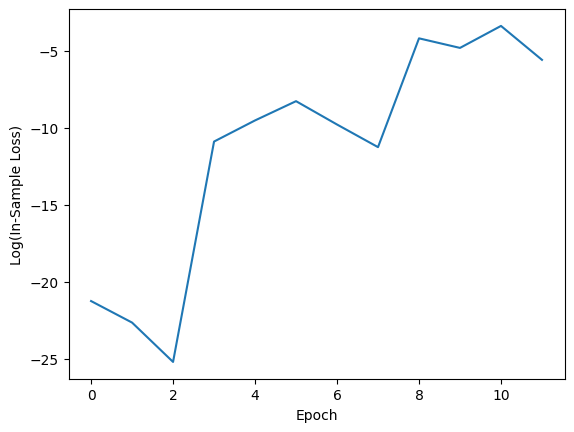

[Parameter containing:
tensor(17.8671, requires_grad=True)]


In [55]:
fig, ax = plt.subplots()
plt.plot( np.array(range(0,num_epochs)), np.array(np.log(train_loss)), label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Log(In-Sample Loss)')



plt.show()
print(list(kernel.parameters()))

Plot and report the in-sample and out of sample loss for the best paramter combination

tensor(2.4754e-05, dtype=torch.float64, grad_fn=<AddBackward0>)


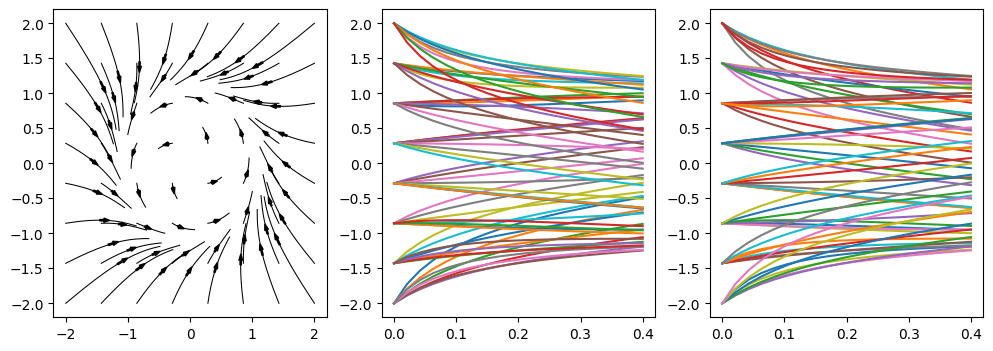

In [57]:
#in sample #########
initial_conditions = np.array(np.meshgrid(np.linspace(-2,2,8), np.linspace(-2, 2,8))).T.reshape(-1, 2)
t_end=0.4#0.0006
timesteps=20

dt=t_end/timesteps
t_eval=np.linspace(0, t_end, timesteps)
trunc=32
factor=1
method = TruncEDMD()

parameter=torch.tensor(11.9905,requires_grad=True) #33.2791   
kernel = RBFKernel([parameter])

x,y,original,t_eval=dynamicshopf(hopf,initial_conditions,t_end,timesteps,factor)
Kernel_results=method.edmd_computations(x.T,y.T,kernel,trunc)

method.preloss_computation_full()
loss = method.loss_full(kernel, x.T, y.T, penalty=True)

f, ax = plt.subplots(1, 3, figsize=(12, 4))

for ic,condition in enumerate(initial_conditions):

    condition=np.array([condition],ndmin=2)
    Fx=method.single_tradjectory(t_eval,condition.T,x.T,y.T,kernel,Kernel_results) 
    
    
   
    ax[0].plot(Fx[:,0],Fx[:,1],color="black",linewidth=0.75)
    ax[1].plot(t_eval,Fx[:,0])
    ax[2].plot(t_eval,Fx[:,1])
    x1=Fx[(timesteps//4), 0]
    y1=Fx[(timesteps//4), 1]
    dx=Fx[(timesteps//4+1), 0]-Fx[(timesteps//4), 0]
    dy=Fx[(timesteps//4+1), 1]-Fx[(timesteps//4), 1]
    ax[0].arrow(x1,y1,dx,dy,width=0.02,color="black")

print(loss)

L2_norm 0.053757695067746435


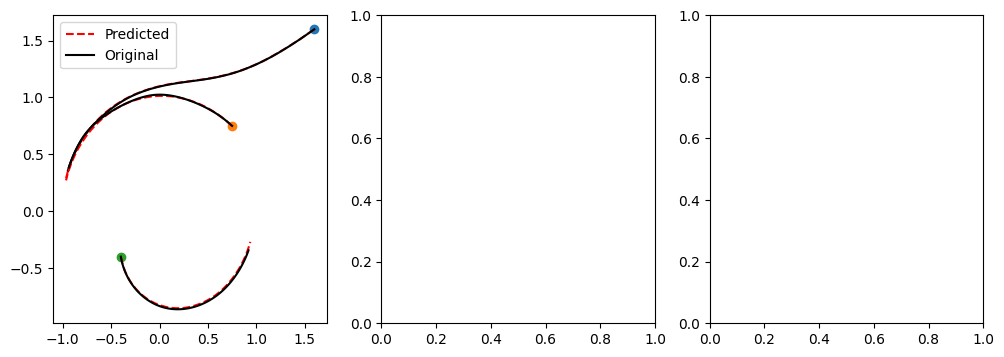

In [33]:
#out of sample specification#################################################################   
f, ax = plt.subplots(1, 3, figsize=(12, 4))
timesteps_sample=100
t_end_sample =timesteps_sample*dt
func=hopf
t_eval_sample = np.linspace(0, t_end_sample, timesteps_sample)
initial_conditions_sample=np.array([[1.6,1.6],[0.75,0.75],[-.4,-0.4]])

sumloss=0
for ic,condition in enumerate(initial_conditions_sample):

        solution,df=get_nonlinear_data(t_eval_sample,condition,func)
        
        condition=np.array([condition],ndmin=2)
 
        predicted=method.single_tradjectory(t_eval_sample,condition.T,x.T,y.T,kernel,Kernel_results)   
        sumloss = sumloss+np.sqrt(np.sum(np.square(predicted-solution))/len(t_eval_sample))
       
        ax[0].plot(predicted[:,0],predicted[:,1],0.1,c="red",linestyle='--', label="Predicted" )   
        ax[0].plot(solution[:,0],solution[:,1],0.1,c="black", label="Original" )  
        ax[0].scatter(condition[:,0],condition[:,1]) 
        
        legend_without_duplicate_labels(ax[0])
l2=sumloss/len(initial_conditions_sample)          

print("L2_norm",l2)     
   
